In [1]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

Cloning into 'Janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 51), reused 36 (delta 36), pack-reused 47 (from 2)
Receiving objects: 100% (121/121), 7.19 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━

In [2]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [3]:
# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: mask_prompt, image_tag, num_image_tokens, ignore_id, sft_format, add_special_token. 


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/89.0k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n What is this place. What is the history behind it.Can you also explain the architectural style and significance of it?",
        "images": ['/content/taj.png'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

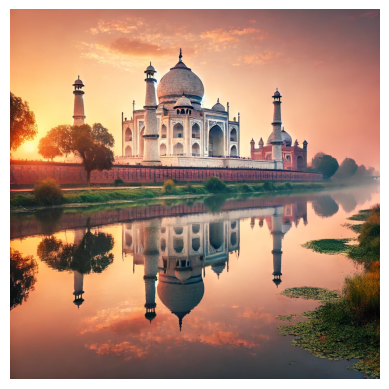

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('/content/taj.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [6]:
# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
 What is this place. What is the history behind it.Can you also explain the architectural style and significance of it?

<|Assistant|>: This is the Taj Mahal, a famous mausoleum located in Agra, India. It was built by the Mughal Emperor Shah Jahan in memory of his wife Mumtaz Mahal, who died during childbirth in 1631. The construction of the Taj Mahal began in 1632 and was completed in 1648, taking around 22 years to complete.

The architectural style of the Taj Mahal is a blend of Islamic, Persian, and Indian architectural elements. It is considered a masterpiece of Mughal architecture and is one of the most recognizable buildings in the world. The main structure is made of white marble and is surrounded by four minarets, each standing 73 meters tall.

The Taj Mahal is s